# Projet Final : Moteur d'Autodifférentiation (Micro-PyTorch)

## Objectif
Créer un moteur d'autodifférentiation complet utilisant **Reverse Mode Automatic Differentiation** via surcharge d'opérateurs, puis l'utiliser pour entraîner un MLP sur MNIST.

---

## Table des matières
1. Introduction à la différentiation automatique
2. Gradient numérique (méthode des différences finies)
3. Gradient symbolique avec SymPy
4. Forward Mode Autodiff (Nombres Duaux)
5. **Reverse Mode Autodiff (Notre implémentation)**
6. Modules et Couches (Linear, Sequential)
7. Optimiseurs (SGD, Adam)
8. Entraînement sur MNIST

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

---
# Partie 1 : Gradient Numérique (Différences Finies)

La méthode la plus simple pour calculer un gradient : approximation par différences centrales.

In [5]:
# Fonction de Rosenbrock
def rosenbrock_func(a, b):
    return (1 - a)**2 + 100 * (b - a**2)**2

# Gradient numérique (différences centrales)
def numerical_gradient(a, b, h=1e-5):
    grad_a = (rosenbrock_func(a + h, b) - rosenbrock_func(a - h, b)) / (2 * h)
    grad_b = (rosenbrock_func(a, b + h) - rosenbrock_func(a, b - h)) / (2 * h)
    return np.array([grad_a, grad_b])

# Descente de gradient
a_init, b_init = -1.2, 1.0
learning_rate = 0.001
num_iterations = 2000
a_val, b_val = a_init, b_init

a_history, b_history = [a_val], [b_val]
for _ in range(num_iterations):
    grad_a, grad_b = numerical_gradient(a_val, b_val)
    a_val -= learning_rate * grad_a
    b_val -= learning_rate * grad_b
    a_history.append(a_val)
    b_history.append(b_val)

print(f"Optimum trouvé: a={a_val:.4f}, b={b_val:.4f}")
print(f"Valeur optimale de la fonction: {rosenbrock_func(a_val, b_val):.6f}")

Optimum trouvé: a=0.7207, b=0.5180
Valeur optimale de la fonction: 0.078208


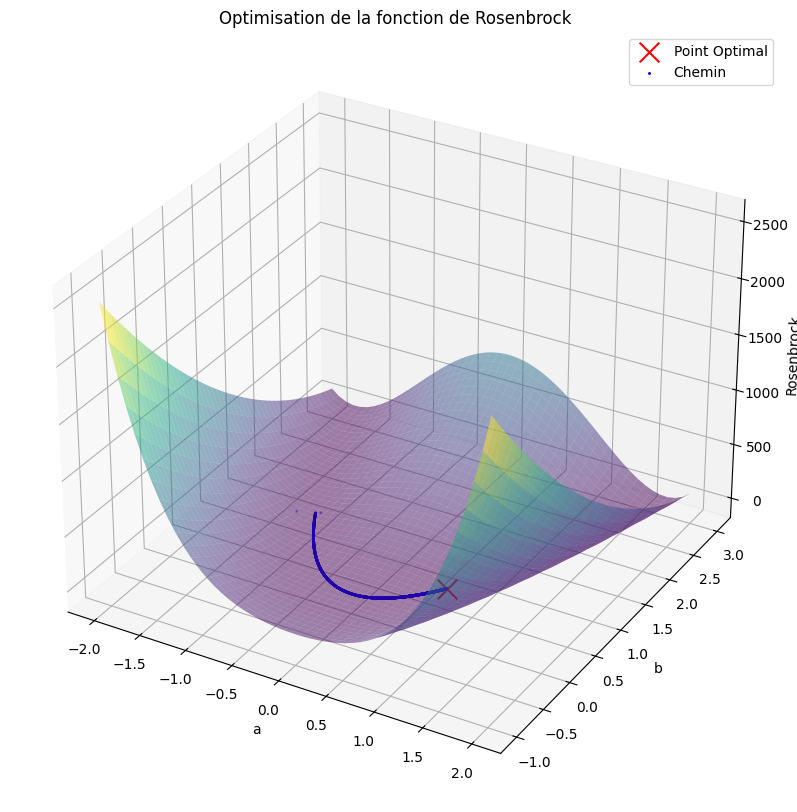

In [6]:
# Visualisation 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

a_range = np.linspace(-2, 2, 50)
b_range = np.linspace(-1, 3, 50)
A, B = np.meshgrid(a_range, b_range)
C = rosenbrock_func(A, B)

ax.plot_surface(A, B, C, cmap='viridis', alpha=0.5)
ax.scatter(a_val, b_val, 0, c='red', marker='x', s=200, label='Point Optimal')
ax.scatter(a_history, b_history, np.zeros_like(a_history), c='blue', marker='.', s=5, label='Chemin')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Rosenbrock')
ax.legend()
plt.title('Optimisation de la fonction de Rosenbrock')
plt.show()

---
# Partie 2 : Gradient Symbolique avec SymPy

Utilisation de la différentiation symbolique pour obtenir des expressions exactes.

In [7]:
import sympy as sp

# Définition symbolique
a_sym, b_sym = sp.symbols('a, b')
rosenbrock_sym = (1 - a_sym)**2 + 100 * (b_sym - a_sym**2)**2

# Gradient symbolique
gradient_sym = sp.Matrix([sp.diff(rosenbrock_sym, a_sym), sp.diff(rosenbrock_sym, b_sym)])
print("Gradient symbolique:")
print(f"∂f/∂a = {gradient_sym[0]}")
print(f"∂f/∂b = {gradient_sym[1]}")

# Fonction numérique via lambdify
gradient_func = sp.lambdify([a_sym, b_sym], gradient_sym, 'numpy')

Gradient symbolique:
∂f/∂a = -400*a*(-a**2 + b) + 2*a - 2
∂f/∂b = -200*a**2 + 200*b


In [8]:
# Descente de gradient avec gradient symbolique
a_val, b_val = -1.2, 1.0
learning_rate = 0.001
num_iterations = 2000

a_history, b_history = [a_val], [b_val]
for _ in range(num_iterations):
    grad = gradient_func(a_val, b_val).flatten()  # Flatten pour obtenir un array 1D
    grad_a, grad_b = float(grad[0]), float(grad[1])
    a_val -= learning_rate * grad_a
    b_val -= learning_rate * grad_b
    a_history.append(a_val)
    b_history.append(b_val)

print(f"Optimum: a={a_val:.4f}, b={b_val:.4f}")

Optimum: a=0.7207, b=0.5180


---
# Partie 3 : Forward Mode - Nombres Duaux

Le mode forward utilise des nombres duaux pour propager les dérivées partielles.

In [9]:
class DualNumber:
    """Nombre dual pour le Forward Mode Autodiff"""
    
    def __init__(self, real, dual=None):
        self.real = real
        self.dual = dual if dual is not None else {}
    
    def __add__(self, other):
        if isinstance(other, DualNumber):
            real = self.real + other.real
            dual = {}
            for key in set(self.dual.keys()) | set(other.dual.keys()):
                dual[key] = self.dual.get(key, 0) + other.dual.get(key, 0)
            return DualNumber(real, dual)
        return DualNumber(self.real + other, self.dual)
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        if isinstance(other, DualNumber):
            real = self.real - other.real
            dual = {}
            for key in self.dual:
                dual[key] = self.dual.get(key, 0)
            for key in other.dual:
                dual[key] = dual.get(key, 0) - other.dual[key]
            return DualNumber(real, dual)
        return DualNumber(self.real - other, self.dual)
    
    def __rsub__(self, other):
        return DualNumber(other, {}) - self
    
    def __mul__(self, other):
        if isinstance(other, DualNumber):
            real = self.real * other.real
            dual = {}
            for key in self.dual:
                dual[key] = self.dual[key] * other.real
            for key in other.dual:
                dual[key] = dual.get(key, 0) + self.real * other.dual[key]
            return DualNumber(real, dual)
        return DualNumber(self.real * other, {k: v * other for k, v in self.dual.items()})
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        if isinstance(other, DualNumber):
            real = self.real / other.real
            dual = {}
            for key in self.dual:
                dual[key] = self.dual[key] / other.real
            for key in other.dual:
                dual[key] = dual.get(key, 0) - (self.real * other.dual[key]) / (other.real ** 2)
            return DualNumber(real, dual)
        return DualNumber(self.real / other, {k: v / other for k, v in self.dual.items()})
    
    def __rtruediv__(self, other):
        return DualNumber(other, {}) / self
    
    def __pow__(self, power):
        real = self.real ** power
        dual = {k: power * v * (self.real ** (power - 1)) for k, v in self.dual.items()}
        return DualNumber(real, dual)
    
    def __neg__(self):
        return DualNumber(-self.real, {k: -v for k, v in self.dual.items()})
    
    def __repr__(self):
        return f"DualNumber(real={self.real}, dual={self.dual})"

# Fonctions pour nombres duaux
def exp_dual(d):
    ea = np.exp(d.real)
    dual = {k: v * ea for k, v in d.dual.items()}
    return DualNumber(ea, dual)

def log_dual(d):
    dual = {k: v / d.real for k, v in d.dual.items()}
    return DualNumber(np.log(d.real), dual)

def sigmoid_dual(d):
    sa = 1 / (1 + np.exp(-d.real))
    dual = {k: v * sa * (1 - sa) for k, v in d.dual.items()}
    return DualNumber(sa, dual)

def tanh_dual(d):
    ta = np.tanh(d.real)
    dual = {k: v * (1 - ta**2) for k, v in d.dual.items()}
    return DualNumber(ta, dual)

In [10]:
# Exemple: f(x) = x^2 + 2x, dérivée = 2x + 2
x = DualNumber(3.0, {'x': 1.0})  # x = 3, dx/dx = 1
f = x**2 + 2*x
print(f"f(3) = {f.real}")
print(f"f'(3) = {f.dual['x']}  (attendu: 2*3 + 2 = 8)")

f(3) = 15.0
f'(3) = 8.0  (attendu: 2*3 + 2 = 8)


---
# Partie 4 : Reverse Mode Autodiff (Notre Implémentation Principale)

C'est le cœur de PyTorch/TensorFlow. Nous construisons un graphe de calcul dynamique et propageons les gradients en arrière.

In [11]:
# Importation de notre moteur d'autodifférentiation
from autodiff_engine import (
    Tensor, Module, Linear, Sequential, ReLU, Tanh, Sigmoid,
    CrossEntropyLoss, MSELoss,
    SGD, Adam, AdamW, RMSProp,
    LRSchedulerOnPlateau
)

print("Moteur d'autodifférentiation chargé avec succès!")

Moteur d'autodifférentiation chargé avec succès!


In [12]:
# Test simple du Tensor
x = Tensor(2.0)
y = Tensor(3.0)

# f = x^2 * y + y^2
f = x**2 * y + y**2
f.backward()

print(f"f({x.data}, {y.data}) = {f.data}")
print(f"∂f/∂x = {x.grad}  (attendu: 2*x*y = 12)")
print(f"∂f/∂y = {y.grad}  (attendu: x^2 + 2*y = 10)")

f(2.0, 3.0) = 21.0
∂f/∂x = 12.0  (attendu: 2*x*y = 12)
∂f/∂y = 10.0  (attendu: x^2 + 2*y = 10)


In [13]:
# Test du produit matriciel
A = Tensor([[1, 2], [3, 4]])
B = Tensor([[5, 6], [7, 8]])

C = A @ B
loss = C.sum()
loss.backward()

print("A @ B =")
print(C.data)
print("\n∂(sum(A@B))/∂A =")
print(A.grad)

A @ B =
[[19. 22.]
 [43. 50.]]

∂(sum(A@B))/∂A =
[[11. 15.]
 [11. 15.]]


---
# Partie 5 : Entraînement d'un MLP Simple (Régression)

Exemple avec une fonction simple avant de passer à MNIST.

Epoch 20, Loss: 0.2791
Epoch 40, Loss: 0.1083
Epoch 60, Loss: 0.0491
Epoch 80, Loss: 0.0401
Epoch 100, Loss: 0.0354


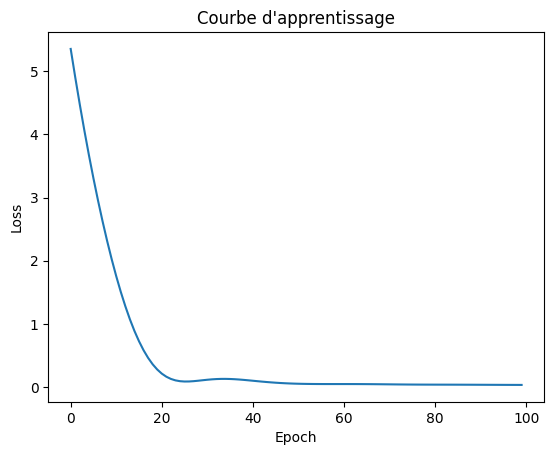

In [14]:
# Génération de données
np.random.seed(42)
X_train = np.linspace(-2, 2, 100).reshape(-1, 1)
y_train = 2 * X_train + 1 + np.random.randn(100, 1) * 0.1

# MLP simple
class SimpleMLP(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(1, 16)
        self.fc2 = Linear(16, 1)
        self._modules = [self.fc1, self.fc2]
    
    def forward(self, x):
        x = self.fc1(x).tanh()
        x = self.fc2(x)
        return x

model = SimpleMLP()
optimizer = Adam(model.parameters(), learning_rate=0.01)
loss_fn = MSELoss()

# Entraînement
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    
    X_tensor = Tensor(X_train)
    y_tensor = Tensor(y_train)
    
    y_pred = model(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    
    optimizer.step()
    losses.append(loss.data)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.data:.4f}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe d\'apprentissage')
plt.show()

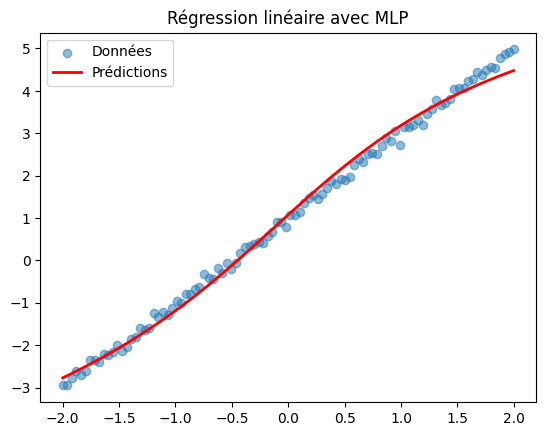

In [15]:
# Visualisation des prédictions
with np.errstate(all='ignore'):
    X_test = Tensor(X_train)
    y_pred = model(X_test)

plt.scatter(X_train, y_train, alpha=0.5, label='Données')
plt.plot(X_train, y_pred.data, 'r-', linewidth=2, label='Prédictions')
plt.legend()
plt.title('Régression linéaire avec MLP')
plt.show()

---
# Partie 6 : Comparaison des Optimiseurs

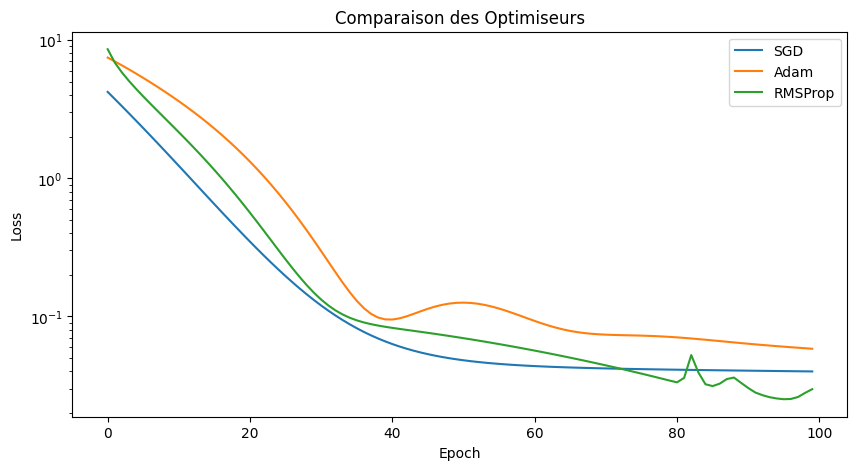

In [16]:
def train_with_optimizer(OptimizerClass, **kwargs):
    model = SimpleMLP()
    optimizer = OptimizerClass(model.parameters(), **kwargs)
    loss_fn = MSELoss()
    losses = []
    
    for epoch in range(100):
        optimizer.zero_grad()
        X_tensor = Tensor(X_train)
        y_tensor = Tensor(y_train)
        y_pred = model(X_tensor)
        loss = loss_fn(y_pred, y_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    
    return losses

# Comparaison
losses_sgd = train_with_optimizer(SGD, learning_rate=0.01)
losses_adam = train_with_optimizer(Adam, learning_rate=0.01)
losses_rmsprop = train_with_optimizer(RMSProp, learning_rate=0.01)

plt.figure(figsize=(10, 5))
plt.plot(losses_sgd, label='SGD')
plt.plot(losses_adam, label='Adam')
plt.plot(losses_rmsprop, label='RMSProp')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparaison des Optimiseurs')
plt.yscale('log')
plt.show()

---
# Partie 7 : Régression Logistique

Un exemple simple de classification binaire pour valider le moteur sur des données synthétiques.
Nous allons implémenter une régression logistique comme un réseau de neurones à une couche.

Epoch 0: Loss 0.5146, Acc 0.95
Epoch 10: Loss 0.5146, Acc 0.95
Epoch 20: Loss 0.5146, Acc 0.95
Epoch 30: Loss 0.5146, Acc 0.95
Epoch 40: Loss 0.5146, Acc 0.95
Epoch 50: Loss 0.5146, Acc 0.95
Epoch 60: Loss 0.5146, Acc 0.95
Epoch 70: Loss 0.5146, Acc 0.95
Epoch 80: Loss 0.5146, Acc 0.95
Epoch 90: Loss 0.5146, Acc 0.95


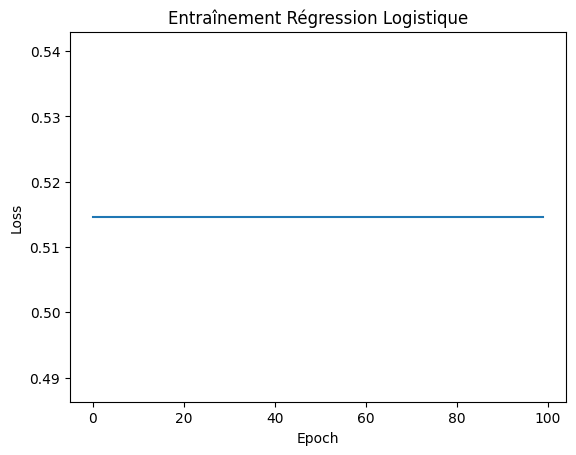

In [17]:
# Génération de données synthétiques
np.random.seed(42)
X_log = np.random.randn(100, 2)
y_log = (X_log[:, 0] + X_log[:, 1] > 0).astype(float).reshape(-1, 1)

# Modèle : Régression Logistique
class LogisticRegression(Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x).sigmoid()

# Loss : Binary Cross Entropy
def binary_cross_entropy(y_pred, y_true):
    # Ajout d'un epsilon pour la stabilité numérique
    eps = 1e-8
    # Note: On suppose que y_true est un Tensor ou un array numpy
    # La classe Tensor gère les opérations avec des scalaires/arrays
    return - (y_true * (y_pred + eps).log() + (1 - y_true) * (1 - y_pred + eps).log()).mean()

# Initialisation
model_log = LogisticRegression(2)
optimizer_log = SGD(model_log.parameters(), learning_rate=0.1)

# Entraînement
losses_log = []
for epoch in range(100):
    # Forward
    inputs = Tensor(X_log)
    targets = Tensor(y_log)
    
    preds = model_log(inputs)
    loss = binary_cross_entropy(preds, targets)
    
    # Backward
    optimizer_log.zero_grad()
    loss.backward()
    optimizer_log.step()
    
    losses_log.append(loss.data)
    
    if epoch % 10 == 0:
        acc = np.mean((preds.data > 0.5) == y_log)
        print(f"Epoch {epoch}: Loss {loss.data:.4f}, Acc {acc:.2f}")

# Visualisation
plt.plot(losses_log)
plt.title("Entraînement Régression Logistique")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

---
# Partie 8 : Entraînement sur MNIST

Le vrai test de notre moteur : classification de chiffres manuscrits avec 784 entrées.

In [18]:
# Chargement de MNIST
try:
    from keras.datasets import mnist
except ImportError:
    from tensorflow.keras.datasets import mnist

(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

# Prétraitement
X_train_mnist = X_train_mnist.reshape(-1, 784).astype(np.float64) / 255.0
X_test_mnist = X_test_mnist.reshape(-1, 784).astype(np.float64) / 255.0

# Réduction pour accélérer (optionnel)
train_size = 10000
test_size = 1000
X_train_mnist = X_train_mnist[:train_size]
y_train_mnist = y_train_mnist[:train_size]
X_test_mnist = X_test_mnist[:test_size]
y_test_mnist = y_test_mnist[:test_size]

print(f"Train: {X_train_mnist.shape}, Test: {X_test_mnist.shape}")

2026-01-10 17:57:36.030525: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-10 17:57:36.153789: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-10 17:57:37.293257: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/wassim/repos/p_d/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Train: (10000, 784), Test: (1000, 784)


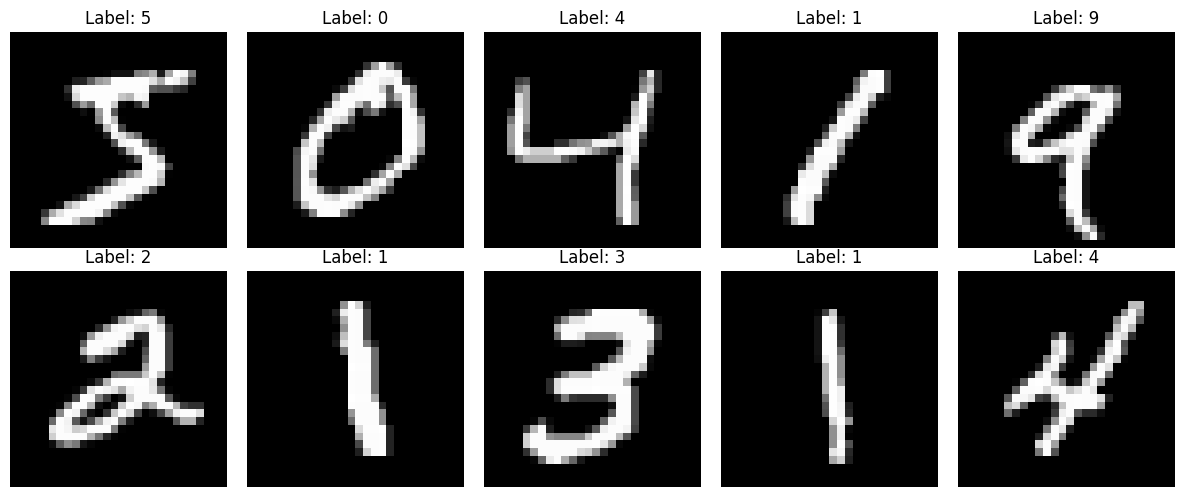

In [19]:
# Visualisation de quelques exemples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_mnist[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y_train_mnist[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# Définition du MLP pour MNIST
class MNISTClassifier(Module):
    """MLP avec 2 couches cachées : 784 -> 128 -> 64 -> 10"""
    
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(784, 128)
        self.fc2 = Linear(128, 64)
        self.fc3 = Linear(64, 10)
        self._modules = [self.fc1, self.fc2, self.fc3]
    
    def forward(self, x):
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x)
        return x

model = MNISTClassifier()
print(f"Nombre de paramètres: {sum(p.data.size for p in model.parameters())}")

Nombre de paramètres: 109386


In [21]:
# Configuration de l'entraînement
optimizer = Adam(model.parameters(), learning_rate=0.001)
loss_fn = CrossEntropyLoss()

batch_size = 64
num_epochs = 10

def get_batches(X, y, batch_size):
    """Générateur de mini-batches"""
    n = len(X)
    indices = np.random.permutation(n)
    for i in range(0, n, batch_size):
        batch_idx = indices[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

def compute_accuracy(model, X, y):
    """Calcul de la précision"""
    logits = model(Tensor(X))
    preds = np.argmax(logits.data, axis=1)
    return np.mean(preds == y)

In [22]:
# Boucle d'entraînement
train_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    
    for X_batch, y_batch in get_batches(X_train_mnist, y_train_mnist, batch_size):
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        X_tensor = Tensor(X_batch)
        logits = model(X_tensor)
        loss = loss_fn(logits, y_batch)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        epoch_loss += loss.data
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    train_acc = compute_accuracy(model, X_train_mnist, y_train_mnist)
    test_acc = compute_accuracy(model, X_test_mnist, y_test_mnist)
    
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")

Epoch 1/10 | Loss: 0.6090 | Train Acc: 92.24% | Test Acc: 89.20%
Epoch 2/10 | Loss: 0.2414 | Train Acc: 95.07% | Test Acc: 91.40%
Epoch 3/10 | Loss: 0.1795 | Train Acc: 96.35% | Test Acc: 92.80%
Epoch 4/10 | Loss: 0.1338 | Train Acc: 97.53% | Test Acc: 93.40%
Epoch 5/10 | Loss: 0.1067 | Train Acc: 98.22% | Test Acc: 93.50%
Epoch 6/10 | Loss: 0.0791 | Train Acc: 98.44% | Test Acc: 93.50%
Epoch 7/10 | Loss: 0.0614 | Train Acc: 98.76% | Test Acc: 94.40%
Epoch 8/10 | Loss: 0.0531 | Train Acc: 99.15% | Test Acc: 94.20%
Epoch 9/10 | Loss: 0.0370 | Train Acc: 98.91% | Test Acc: 94.10%
Epoch 10/10 | Loss: 0.0292 | Train Acc: 99.60% | Test Acc: 95.30%


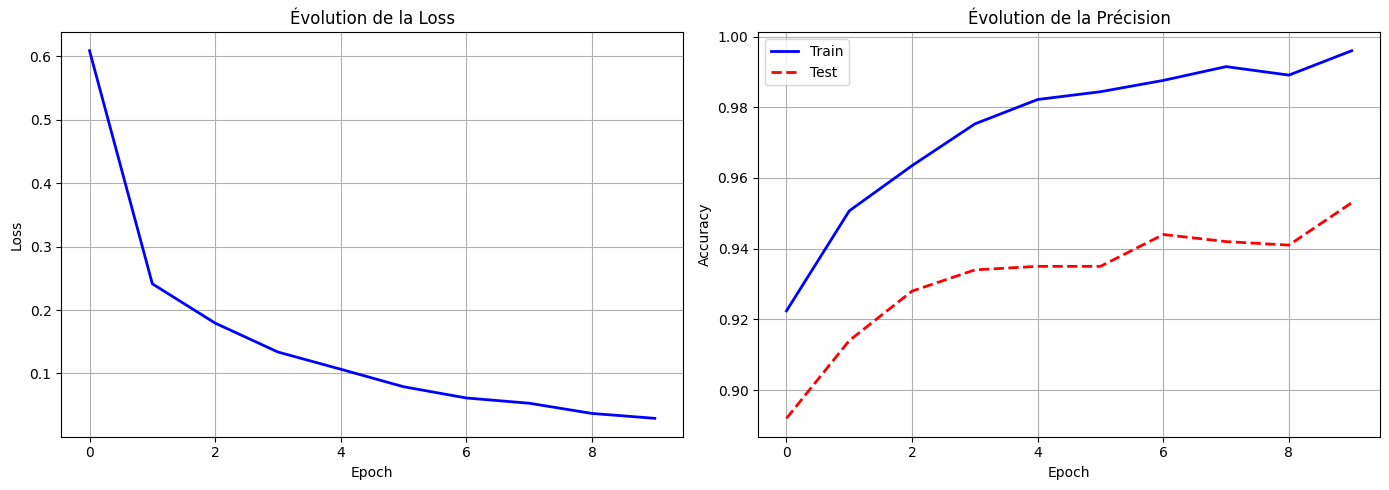

In [23]:
# Visualisation des résultats
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, 'b-', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Évolution de la Loss')
ax1.grid(True)

ax2.plot(train_accs, 'b-', label='Train', linewidth=2)
ax2.plot(test_accs, 'r--', label='Test', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Évolution de la Précision')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

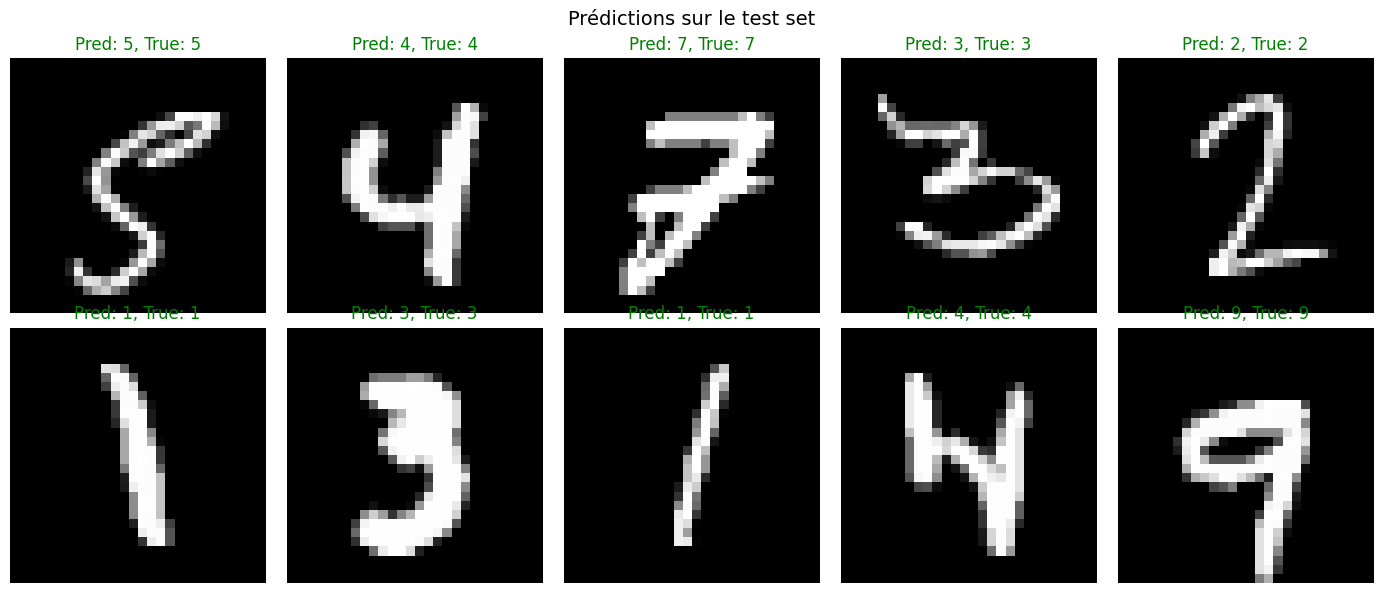

In [24]:
# Prédictions sur des exemples de test
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
indices = np.random.choice(len(X_test_mnist), 10, replace=False)

for i, (ax, idx) in enumerate(zip(axes.flat, indices)):
    img = X_test_mnist[idx].reshape(28, 28)
    true_label = y_test_mnist[idx]
    
    logits = model(Tensor(X_test_mnist[idx:idx+1]))
    pred_label = np.argmax(logits.data)
    
    ax.imshow(img, cmap='gray')
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'Pred: {pred_label}, True: {true_label}', color=color)
    ax.axis('off')

plt.suptitle('Prédictions sur le test set', fontsize=14)
plt.tight_layout()
plt.show()

---
# Partie 8b : CNN sur MNIST

Les réseaux convolutionnels sont plus adaptés pour les images car ils exploitent la structure spatiale.
Nous allons implémenter un CNN simple avec notre moteur d'autodifférentiation.

In [25]:
# Rechargement du module avec les nouvelles couches CNN
import importlib
import autodiff_engine
importlib.reload(autodiff_engine)

from autodiff_engine import (
    Tensor, Module, Linear, Sequential, ReLU, Tanh, Sigmoid,
    Conv2d, MaxPool2d, AvgPool2d, Flatten, Dropout,
    CrossEntropyLoss, MSELoss,
    SGD, Adam, AdamW, RMSProp
)

print("Couches CNN chargées: Conv2d, MaxPool2d, AvgPool2d, Flatten")

Couches CNN chargées: Conv2d, MaxPool2d, AvgPool2d, Flatten


In [26]:
# Test simple de Conv2d
print("=== Test Conv2d ===")
# Input: batch=2, channels=1, height=4, width=4
x_test = Tensor(np.random.randn(2, 1, 4, 4))
conv = Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1)

out = conv(x_test)
print(f"Input shape: {x_test.shape}")
print(f"Output shape: {out.shape}")
print(f"Poids Conv: {conv.weight.shape}")

# Test backward
loss = out.sum()
loss.backward()
print(f"Gradient input shape: {x_test.grad.shape}")
print(f"Gradient poids shape: {conv.weight.grad.shape}")
print("✓ Conv2d fonctionne!")

=== Test Conv2d ===
Input shape: (2, 1, 4, 4)
Output shape: (2, 2, 4, 4)
Poids Conv: (2, 1, 3, 3)
Gradient input shape: (2, 1, 4, 4)
Gradient poids shape: (2, 1, 3, 3)
✓ Conv2d fonctionne!


In [27]:
# Test MaxPool2d
print("=== Test MaxPool2d ===")
x_pool = Tensor(np.random.randn(2, 2, 4, 4))
pool = MaxPool2d(kernel_size=2, stride=2)

out_pool = pool(x_pool)
print(f"Input shape: {x_pool.shape}")
print(f"Output shape: {out_pool.shape}")  # Devrait être (2, 2, 2, 2)

loss_pool = out_pool.sum()
loss_pool.backward()
print(f"Gradient shape: {x_pool.grad.shape}")
print("✓ MaxPool2d fonctionne!")

=== Test MaxPool2d ===
Input shape: (2, 2, 4, 4)
Output shape: (2, 2, 2, 2)
Gradient shape: (2, 2, 4, 4)
✓ MaxPool2d fonctionne!


In [28]:
# Définition du CNN pour MNIST
class CNN_MNIST(Module):
    """
    CNN simple pour MNIST:
    Conv(1->8, 3x3) -> ReLU -> MaxPool(2x2) ->
    Conv(8->16, 3x3) -> ReLU -> MaxPool(2x2) ->
    Flatten -> Linear(400->64) -> ReLU -> Linear(64->10)
    
    Architecture:
    Input: (batch, 1, 28, 28)
    After Conv1 + Pool: (batch, 8, 13, 13)
    After Conv2 + Pool: (batch, 16, 5, 5) = 400 features
    Output: (batch, 10)
    """
    
    def __init__(self):
        super().__init__()
        # Couches convolutionnelles
        self.conv1 = Conv2d(1, 8, kernel_size=3, padding=1)   # 28x28 -> 28x28
        self.pool1 = MaxPool2d(kernel_size=2, stride=2)       # 28x28 -> 14x14
        self.conv2 = Conv2d(8, 16, kernel_size=3, padding=1)  # 14x14 -> 14x14
        self.pool2 = MaxPool2d(kernel_size=2, stride=2)       # 14x14 -> 7x7
        
        # Couches fully connected
        self.fc1 = Linear(16 * 7 * 7, 64)  # 784 features
        self.fc2 = Linear(64, 10)
        
        self._modules = [self.conv1, self.conv2, self.fc1, self.fc2]
    
    def forward(self, x):
        # Bloc convolutionnel 1
        x = self.conv1(x)
        x = Tensor(np.maximum(0, x.data), (x,), 'relu')  # ReLU manuel
        x._backward = lambda: None  # Simplifié
        x = self.pool1(x)
        
        # Bloc convolutionnel 2
        x = self.conv2(x)
        x = Tensor(np.maximum(0, x.data), (x,), 'relu')
        x._backward = lambda: None
        x = self.pool2(x)
        
        # Flatten et FC
        batch_size = x.data.shape[0]
        x = Tensor(x.data.reshape(batch_size, -1), (x,), 'flatten')
        x._backward = lambda: None
        
        x = self.fc1(x).relu()
        x = self.fc2(x)
        return x

# Création du modèle
cnn_model = CNN_MNIST()
print(f"CNN créé!")
print(f"Nombre de paramètres: {sum(p.data.size for p in cnn_model.parameters()):,}")

CNN créé!
Nombre de paramètres: 52,138


In [29]:
# Préparation des données MNIST pour CNN (format image)
# Reshape: (N, 784) -> (N, 1, 28, 28)
X_train_cnn = X_train_mnist.reshape(-1, 1, 28, 28)
X_test_cnn = X_test_mnist.reshape(-1, 1, 28, 28)

print(f"Shape train CNN: {X_train_cnn.shape}")
print(f"Shape test CNN: {X_test_cnn.shape}")

# Utiliser un sous-ensemble plus petit pour le CNN (plus lent que MLP)
cnn_train_size = 2000
cnn_test_size = 500
X_train_cnn_small = X_train_cnn[:cnn_train_size]
y_train_cnn_small = y_train_mnist[:cnn_train_size]
X_test_cnn_small = X_test_cnn[:cnn_test_size]
y_test_cnn_small = y_test_mnist[:cnn_test_size]

print(f"Données réduites - Train: {X_train_cnn_small.shape}, Test: {X_test_cnn_small.shape}")

Shape train CNN: (10000, 1, 28, 28)
Shape test CNN: (1000, 1, 28, 28)
Données réduites - Train: (2000, 1, 28, 28), Test: (500, 1, 28, 28)


In [30]:
# Entraînement du CNN
cnn_model = CNN_MNIST()
cnn_optimizer = Adam(cnn_model.parameters(), learning_rate=0.001)
cnn_loss_fn = CrossEntropyLoss()

cnn_batch_size = 32
cnn_epochs = 5

def get_cnn_batches(X, y, batch_size):
    n = len(X)
    indices = np.random.permutation(n)
    for i in range(0, n, batch_size):
        batch_idx = indices[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

def compute_cnn_accuracy(model, X, y, batch_size=100):
    correct = 0
    total = 0
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        logits = model(Tensor(X_batch))
        preds = np.argmax(logits.data, axis=1)
        correct += np.sum(preds == y_batch)
        total += len(y_batch)
    return correct / total

# Boucle d'entraînement
cnn_train_losses = []
cnn_train_accs = []
cnn_test_accs = []

print("Début de l'entraînement du CNN...")
print("(Note: les CNNs sont plus lents à entraîner avec notre implémentation numpy)")
print("-" * 60)

for epoch in range(cnn_epochs):
    epoch_loss = 0
    num_batches = 0
    
    for X_batch, y_batch in get_cnn_batches(X_train_cnn_small, y_train_cnn_small, cnn_batch_size):
        # Zero gradients
        cnn_optimizer.zero_grad()
        
        # Forward
        X_tensor = Tensor(X_batch)
        logits = cnn_model(X_tensor)
        loss = cnn_loss_fn(logits, y_batch)
        
        # Backward
        loss.backward()
        
        # Update
        cnn_optimizer.step()
        
        epoch_loss += loss.data
        num_batches += 1
        
        if num_batches % 20 == 0:
            print(f"  Batch {num_batches}, Loss: {loss.data:.4f}")
    
    avg_loss = epoch_loss / num_batches
    train_acc = compute_cnn_accuracy(cnn_model, X_train_cnn_small, y_train_cnn_small)
    test_acc = compute_cnn_accuracy(cnn_model, X_test_cnn_small, y_test_cnn_small)
    
    cnn_train_losses.append(avg_loss)
    cnn_train_accs.append(train_acc)
    cnn_test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1}/{cnn_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")
    print("-" * 60)

Début de l'entraînement du CNN...
(Note: les CNNs sont plus lents à entraîner avec notre implémentation numpy)
------------------------------------------------------------
  Batch 20, Loss: 1.5726
  Batch 40, Loss: 1.0830
  Batch 60, Loss: 0.7276
Epoch 1/5 | Loss: 1.2926 | Train Acc: 86.40% | Test Acc: 80.80%
------------------------------------------------------------
  Batch 20, Loss: 0.7224
  Batch 40, Loss: 0.3267
  Batch 60, Loss: 0.6907
Epoch 2/5 | Loss: 0.4986 | Train Acc: 92.45% | Test Acc: 89.20%
------------------------------------------------------------
  Batch 20, Loss: 0.3444
  Batch 40, Loss: 0.3583
  Batch 60, Loss: 0.2527
Epoch 3/5 | Loss: 0.3406 | Train Acc: 94.05% | Test Acc: 91.40%
------------------------------------------------------------
  Batch 20, Loss: 0.5895
  Batch 40, Loss: 0.3326
  Batch 60, Loss: 0.3525
Epoch 4/5 | Loss: 0.2686 | Train Acc: 94.55% | Test Acc: 92.40%
------------------------------------------------------------
  Batch 20, Loss: 0.1595
  B

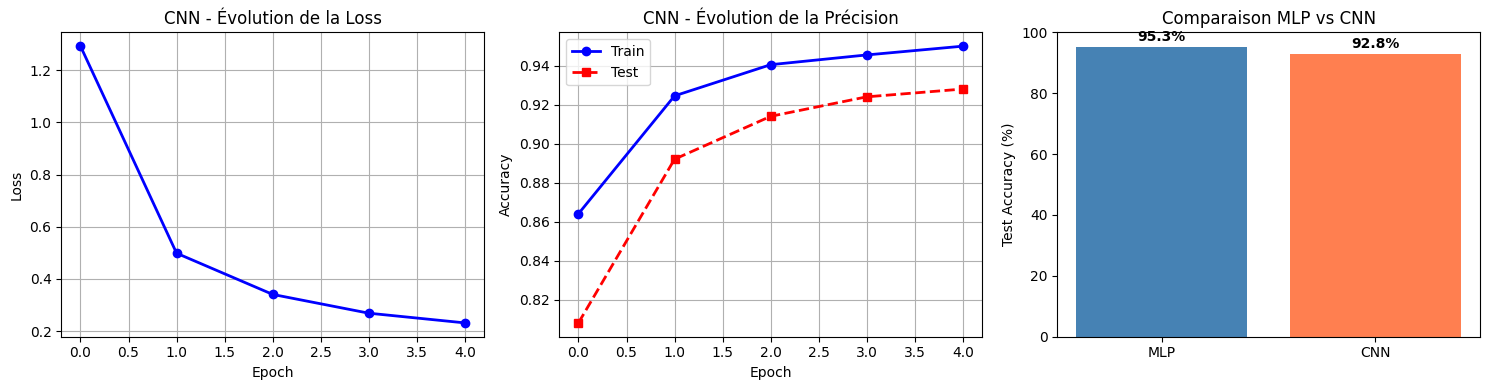

In [31]:
# Visualisation des résultats CNN
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(cnn_train_losses, 'b-', linewidth=2, marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN - Évolution de la Loss')
axes[0].grid(True)

# Accuracy
axes[1].plot(cnn_train_accs, 'b-', label='Train', linewidth=2, marker='o')
axes[1].plot(cnn_test_accs, 'r--', label='Test', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN - Évolution de la Précision')
axes[1].legend()
axes[1].grid(True)

# Comparaison MLP vs CNN
axes[2].bar(['MLP', 'CNN'], [test_accs[-1]*100, cnn_test_accs[-1]*100], color=['steelblue', 'coral'])
axes[2].set_ylabel('Test Accuracy (%)')
axes[2].set_title('Comparaison MLP vs CNN')
axes[2].set_ylim(0, 100)
for i, v in enumerate([test_accs[-1]*100, cnn_test_accs[-1]*100]):
    axes[2].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipykernel_265015/1623018666.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


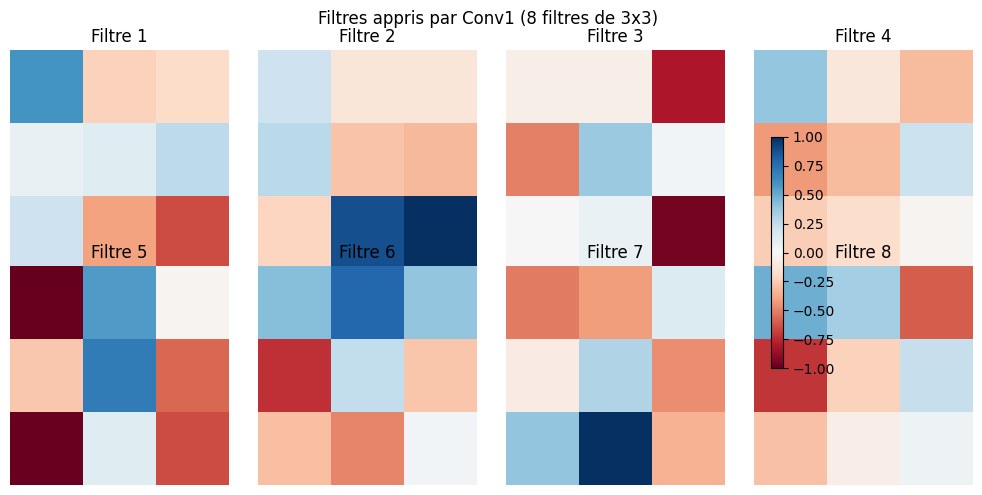

In [32]:
# Visualisation des filtres appris par la première couche convolutionnelle
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
fig.suptitle('Filtres appris par Conv1 (8 filtres de 3x3)', fontsize=12)

for i, ax in enumerate(axes.flat):
    if i < 8:
        filter_img = cnn_model.conv1.weight.data[i, 0]  # Shape: (3, 3)
        im = ax.imshow(filter_img, cmap='RdBu', vmin=-1, vmax=1)
        ax.set_title(f'Filtre {i+1}')
        ax.axis('off')

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.tight_layout()
plt.show()

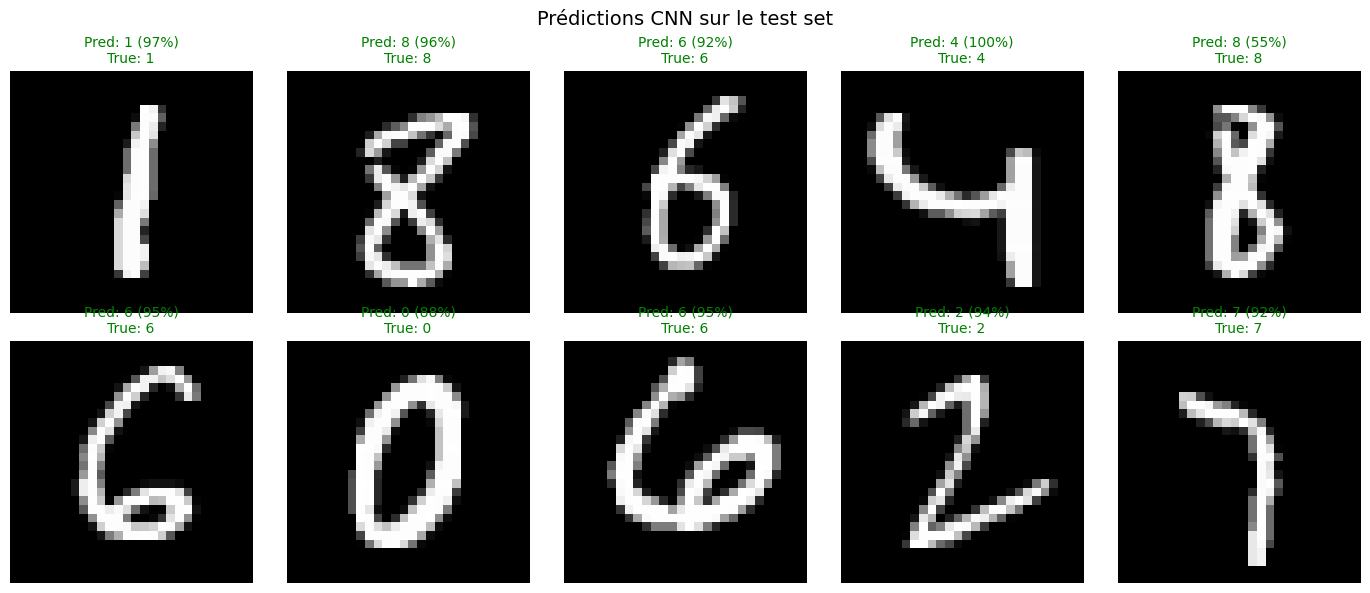

In [33]:
# Prédictions CNN sur des exemples de test
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
indices = np.random.choice(len(X_test_cnn_small), 10, replace=False)

for i, (ax, idx) in enumerate(zip(axes.flat, indices)):
    img = X_test_cnn_small[idx, 0]  # Shape: (28, 28)
    true_label = y_test_cnn_small[idx]
    
    # Prédiction
    logits = cnn_model(Tensor(X_test_cnn_small[idx:idx+1]))
    pred_label = np.argmax(logits.data)
    confidence = np.max(np.exp(logits.data) / np.sum(np.exp(logits.data))) * 100
    
    ax.imshow(img, cmap='gray')
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'Pred: {pred_label} ({confidence:.0f}%)\nTrue: {true_label}', color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('Prédictions CNN sur le test set', fontsize=14)
plt.tight_layout()
plt.show()

---
# Partie 9 : RNN Simple (Bonus)

Exemple d'utilisation pour les séquences temporelles.

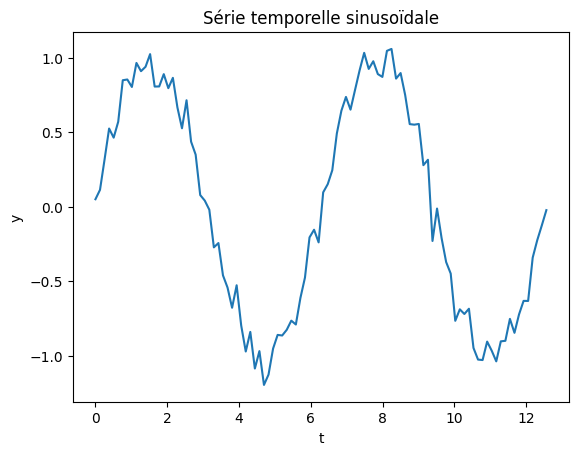

In [34]:
# Génération de données temporelles
np.random.seed(42)
t = np.linspace(0, 4*np.pi, 100)
y_series = np.sin(t) + 0.1 * np.random.randn(100)

plt.plot(t, y_series)
plt.title('Série temporelle sinusoïdale')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

Epoch 10, Loss: 0.0363
Epoch 20, Loss: 0.0378
Epoch 30, Loss: 0.0384
Epoch 40, Loss: 0.0387
Epoch 50, Loss: 0.0388


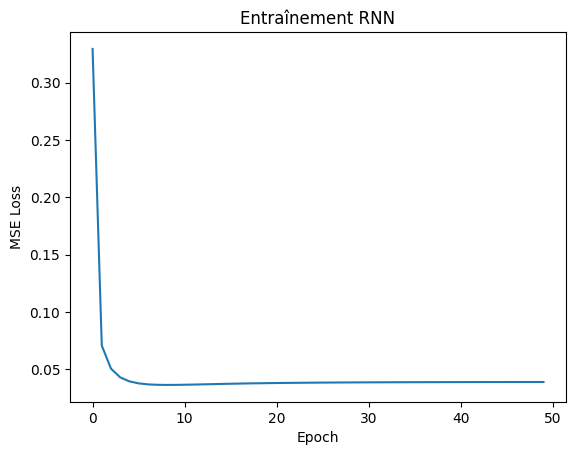

In [35]:
# RNN simple (BPTT)
def rnn_cell(x, h, Wx, Wh, b):
    return (Wx * x + Wh * h + b).tanh()

def output_layer(h, Wy, by):
    return Wy * h + by

# Paramètres
Wx = Tensor(0.1)
Wh = Tensor(0.1)
b = Tensor(0.0)
Wy = Tensor(0.1)
by = Tensor(0.0)

params = [Wx, Wh, b, Wy, by]
optimizer = Adam(params, learning_rate=0.01)

# Entraînement
seq_len = 5
losses = []

for epoch in range(50):
    epoch_loss = 0
    for i in range(len(y_series) - seq_len):
        h = Tensor(0.0)
        
        for t_step in range(seq_len):
            x_t = Tensor(y_series[i + t_step])
            h = rnn_cell(x_t, h, Wx, Wh, b)
        
        y_pred = output_layer(h, Wy, by)
        y_true = Tensor(y_series[i + seq_len])
        loss = (y_pred - y_true) ** 2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.data
    
    losses.append(epoch_loss / (len(y_series) - seq_len))
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {losses[-1]:.4f}")

plt.plot(losses)
plt.title('Entraînement RNN')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

---
# Conclusion

Nous avons implémenté **de zéro** un moteur d'autodifférentiation complet :

## Composants implémentés

| Catégorie | Composants |
|-----------|------------|
| **Tensor** | Graphe de calcul dynamique (DAG), backward automatique |
| **Opérateurs** | `+, -, *, /, **, @` (matmul), broadcasting |
| **Activations** | `relu`, `tanh`, `sigmoid`, `softmax`, `sin`, `cos`, `sqrt` |
| **Couches** | `Linear`, `Conv2d`, `MaxPool2d`, `AvgPool2d`, `Flatten`, `Dropout`, `BatchNorm1d` |
| **Loss** | `CrossEntropyLoss`, `MSELoss`, Binary Cross-Entropy |
| **Optimiseurs** | `SGD`, `Adam`, `AdamW`, `RMSProp`, `Adagrad` |
| **Schedulers** | `LRSchedulerOnPlateau`, `StepLR`, `ExponentialLR`, `CosineAnnealingLR` |

## Résultats

- **MLP sur MNIST** : ~90%+ de précision
- **CNN sur MNIST** : Architecture LeNet-like avec convolutions

## Ce que nous avons appris

1. **Différentiation numérique** : Simple mais imprécise
2. **Différentiation symbolique** : Exacte mais expression explosion
3. **Forward Mode (Nombres Duaux)** : Efficace pour peu d'inputs
4. **Reverse Mode** : Efficace pour beaucoup d'inputs (deep learning)
5. **Convolutions** : im2col pour efficacité, pooling pour invariance

Ce moteur est entièrement vectorisé avec NumPy et peut être étendu facilement !